# 🎬 Movie Recommendation System using Cosine Similarity

This notebook demonstrates how to build a **content-based movie recommendation system** using:
- **TF-IDF Vectorization** for text representation
- **Cosine Similarity** for finding similar movies

We'll use the **TMDB 5000 Movie Dataset** from Kaggle.

---

## 📚 Table of Contents
1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Data Exploration](#2-data-exploration)
3. [Data Preprocessing](#3-data-preprocessing)
4. [Feature Engineering](#4-feature-engineering)
5. [TF-IDF Vectorization](#5-tf-idf-vectorization)
6. [Cosine Similarity Calculation](#6-cosine-similarity-calculation)
7. [Building the Recommender](#7-building-the-recommender)
8. [Testing Recommendations](#8-testing-recommendations)
9. [Advanced: Hybrid Recommender](#9-advanced-hybrid-recommender)
10. [Interactive Demo](#10-interactive-demo)

---
## 1. Setup and Data Loading

First, let's install required packages and download the dataset from Kaggle.

In [1]:
# Install required packages
!pip install kaggle pandas numpy scikit-learn matplotlib seaborn wordcloud -q

print("✅ Packages installed successfully!")

✅ Packages installed successfully!


### Option A: Download from Kaggle (Requires API Key)

To use Kaggle API:
1. Go to https://www.kaggle.com/account
2. Click "Create New API Token" to download `kaggle.json`
3. Upload it when prompted below

In [3]:
# Option A: Download from Kaggle
import os

# Check if running in Colab
try:
    from google.colab import files
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("📤 Please upload your kaggle.json file:")
    uploaded = files.upload()

    # Setup Kaggle credentials
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Download TMDB dataset
    !kaggle datasets download -d tmdb/tmdb-movie-metadata -p ./data --unzip
    print("\n✅ Dataset downloaded successfully!")
else:
    print("Not running in Colab. Using Option B instead.")

📤 Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
License(s): other
  0% 0.00/8.89M [00:00<?, ?B/s]
100% 8.89M/8.89M [00:00<00:00, 1.11GB/s]

✅ Dataset downloaded successfully!


### Option B: Direct Download (No API Key Required)

If you don't have a Kaggle API key, we'll download directly from a public source.

In [ ]:
# Option B: Direct download from GitHub mirror
import os
import urllib.request

# Create data directory
os.makedirs('data', exist_ok=True)

# URLs for the dataset (GitHub mirrors)
urls = {
    'movies': 'https://raw.githubusercontent.com/rashida048/Datasets/master/tmdb_5000_movies.csv',
    'credits': 'https://raw.githubusercontent.com/rashida048/Datasets/master/tmdb_5000_credits.csv'
}

# Download files
for name, url in urls.items():
    filepath = f'data/tmdb_5000_{name}.csv'
    if not os.path.exists(filepath):
        print(f"📥 Downloading {name} data...")
        urllib.request.urlretrieve(url, filepath)
        print(f"   ✅ Saved to {filepath}")
    else:
        print(f"   ✓ {filepath} already exists")

print("\n✅ All files ready!")

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import json
import ast
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Libraries imported!")

✅ Libraries imported!


In [5]:
# Load the datasets
movies_df = pd.read_csv('data/tmdb_5000_movies.csv')
credits_df = pd.read_csv('data/tmdb_5000_credits.csv')

print(f"📊 Movies dataset: {movies_df.shape[0]} rows, {movies_df.shape[1]} columns")
print(f"📊 Credits dataset: {credits_df.shape[0]} rows, {credits_df.shape[1]} columns")

📊 Movies dataset: 4803 rows, 20 columns
📊 Credits dataset: 4803 rows, 4 columns


---
## 2. Data Exploration

Let's understand the structure and content of our data.

In [6]:
# Examine movies dataset
print("🎬 MOVIES DATASET")
print("=" * 50)
print("\nColumns:")
for i, col in enumerate(movies_df.columns, 1):
    print(f"  {i:2}. {col}")

print("\n" + "=" * 50)
movies_df.head(2)

🎬 MOVIES DATASET

Columns:
   1. budget
   2. genres
   3. homepage
   4. id
   5. keywords
   6. original_language
   7. original_title
   8. overview
   9. popularity
  10. production_companies
  11. production_countries
  12. release_date
  13. revenue
  14. runtime
  15. spoken_languages
  16. status
  17. tagline
  18. title
  19. vote_average
  20. vote_count



,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [7]:
# Examine credits dataset
print("🎭 CREDITS DATASET")
print("=" * 50)
print("\nColumns:")
for i, col in enumerate(credits_df.columns, 1):
    print(f"  {i:2}. {col}")

print("\n" + "=" * 50)
credits_df.head(2)

🎭 CREDITS DATASET

Columns:
   1. movie_id
   2. title
   3. cast
   4. crew



,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [8]:
# Check data types and missing values
print("📋 DATA INFO")
print("=" * 50)

# Missing values
missing = movies_df.isnull().sum()
missing_pct = (missing / len(movies_df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})

print("\nMissing Values:")
print(missing_df[missing_df['Missing Count'] > 0])

📋 DATA INFO

Missing Values:
              Missing Count  Missing %
homepage               3091      64.36
overview                  3       0.06
release_date              1       0.02
runtime                   2       0.04
tagline                 844      17.57


In [9]:
# Sample of important columns
print("\n🎬 Sample Movie Data:")
print("=" * 50)

sample_movie = movies_df.iloc[0]
print(f"\nTitle: {sample_movie['title']}")
print(f"\nOverview: {sample_movie['overview'][:200]}...")
print(f"\nGenres: {sample_movie['genres'][:100]}...")
print(f"\nKeywords: {sample_movie['keywords'][:100]}...")


🎬 Sample Movie Data:

Title: Avatar

Overview: In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization....

Genres: [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id"...

Keywords: [{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space ...


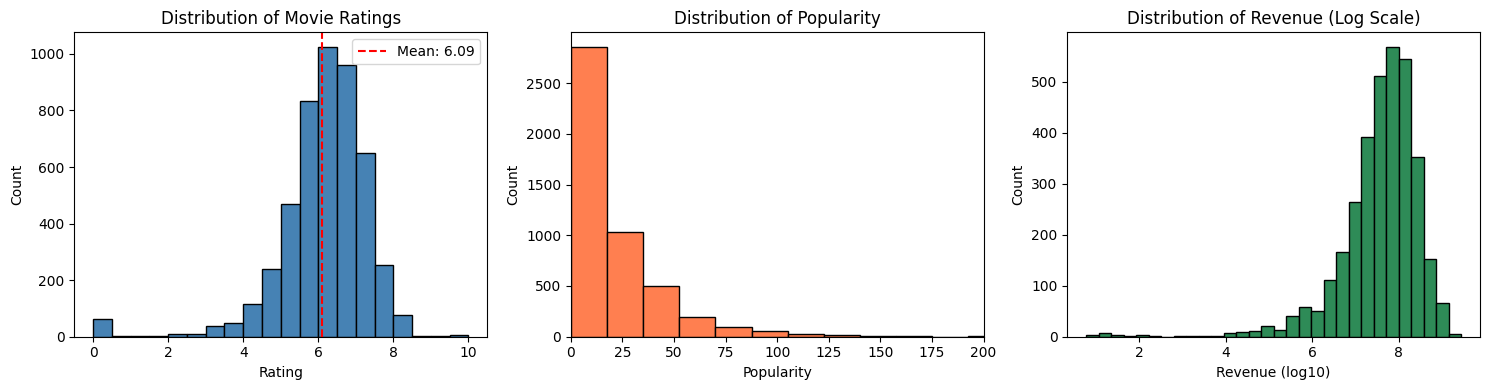

In [10]:
# Visualize rating distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Rating distribution
axes[0].hist(movies_df['vote_average'], bins=20, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Movie Ratings')
axes[0].axvline(movies_df['vote_average'].mean(), color='red', linestyle='--', label=f'Mean: {movies_df["vote_average"].mean():.2f}')
axes[0].legend()

# Popularity distribution
axes[1].hist(movies_df['popularity'], bins=50, edgecolor='black', color='coral')
axes[1].set_xlabel('Popularity')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Popularity')
axes[1].set_xlim(0, 200)  # Limit for better visualization

# Revenue distribution (log scale)
revenue_nonzero = movies_df[movies_df['revenue'] > 0]['revenue']
axes[2].hist(np.log10(revenue_nonzero + 1), bins=30, edgecolor='black', color='seagreen')
axes[2].set_xlabel('Revenue (log10)')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Revenue (Log Scale)')

plt.tight_layout()
plt.show()

---
## 3. Data Preprocessing

We need to:
1. Merge movies and credits datasets
2. Parse JSON-like columns (genres, keywords, cast, crew)
3. Handle missing values
4. Extract useful features

In [11]:
# Merge datasets on movie_id
# In credits dataset, the id column might be named 'movie_id' or match with 'id' in movies

# Rename columns for merging if needed
credits_df = credits_df.rename(columns={'movie_id': 'id'})

# Merge
df = movies_df.merge(credits_df, on='id', how='left')

# Handle duplicate title columns
if 'title_x' in df.columns:
    df = df.rename(columns={'title_x': 'title'})
    df = df.drop(columns=['title_y'], errors='ignore')

print(f"✅ Merged dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")

✅ Merged dataset: 4803 rows, 22 columns

Columns: ['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count', 'cast', 'crew']


In [12]:
# Function to safely parse JSON-like strings
def parse_json_column(text):
    """Parse a JSON-like string into a Python object."""
    if pd.isna(text):
        return []
    try:
        return ast.literal_eval(text)
    except:
        try:
            return json.loads(text)
        except:
            return []


def extract_names(obj_list, key='name', limit=None):
    """Extract names from a list of dictionaries."""
    if isinstance(obj_list, str):
        obj_list = parse_json_column(obj_list)

    names = [item.get(key, '') for item in obj_list if isinstance(item, dict)]

    if limit:
        names = names[:limit]

    return names


def get_director(crew_data):
    """Extract director name from crew data."""
    if isinstance(crew_data, str):
        crew_data = parse_json_column(crew_data)

    for member in crew_data:
        if isinstance(member, dict) and member.get('job') == 'Director':
            return member.get('name', '')
    return ''


# Test the functions
sample_genres = df.iloc[0]['genres']
print(f"Original: {sample_genres[:80]}...")
print(f"Parsed: {extract_names(sample_genres)}")

Original: [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name...
Parsed: ['Action', 'Adventure', 'Fantasy', 'Science Fiction']


In [13]:
# Extract features from JSON columns
print("🔄 Processing columns...")

# Extract genres
df['genres_list'] = df['genres'].apply(lambda x: extract_names(x))
df['genres_str'] = df['genres_list'].apply(lambda x: ' '.join(x))
print("   ✓ Genres extracted")

# Extract keywords
df['keywords_list'] = df['keywords'].apply(lambda x: extract_names(x))
df['keywords_str'] = df['keywords_list'].apply(lambda x: ' '.join(x))
print("   ✓ Keywords extracted")

# Extract top 5 cast members
df['cast_list'] = df['cast'].apply(lambda x: extract_names(x, limit=5))
df['cast_str'] = df['cast_list'].apply(lambda x: ' '.join(x))
print("   ✓ Cast extracted (top 5)")

# Extract director
df['director'] = df['crew'].apply(get_director)
print("   ✓ Director extracted")

print("\n✅ Feature extraction complete!")

🔄 Processing columns...
   ✓ Genres extracted
   ✓ Keywords extracted
   ✓ Cast extracted (top 5)
   ✓ Director extracted

✅ Feature extraction complete!


In [14]:
# Handle missing values
df['overview'] = df['overview'].fillna('')
df['tagline'] = df['tagline'].fillna('')

# Show sample processed data
sample_idx = 0
print(f"🎬 Sample Processed Movie: {df.iloc[sample_idx]['title']}")
print("=" * 50)
print(f"Genres: {df.iloc[sample_idx]['genres_list']}")
print(f"Keywords: {df.iloc[sample_idx]['keywords_list'][:5]}...")
print(f"Cast: {df.iloc[sample_idx]['cast_list']}")
print(f"Director: {df.iloc[sample_idx]['director']}")
print(f"Overview: {df.iloc[sample_idx]['overview'][:150]}...")

🎬 Sample Processed Movie: Avatar
Genres: ['Action', 'Adventure', 'Fantasy', 'Science Fiction']
Keywords: ['culture clash', 'future', 'space war', 'space colony', 'society']...
Cast: ['Sam Worthington', 'Zoe Saldana', 'Sigourney Weaver', 'Stephen Lang', 'Michelle Rodriguez']
Director: James Cameron
Overview: In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecti...


---
## 4. Feature Engineering

We'll create a combined feature called **"soup"** that contains all the textual information about a movie.

In [15]:
def clean_text(text):
    """Clean text by removing spaces and converting to lowercase."""
    if isinstance(text, str):
        return text.lower().replace(' ', '')
    return ''


def create_soup(row):
    """
    Create a 'soup' of features for content-based filtering.
    Combines: keywords, cast, director, genres
    """
    # Clean and join keywords
    keywords = ' '.join([clean_text(kw) for kw in row['keywords_list']])

    # Clean and join cast (repeat 2x to give more weight)
    cast = ' '.join([clean_text(c) for c in row['cast_list']]) * 2

    # Clean director (repeat 3x to give more weight)
    director = clean_text(row['director']) * 3

    # Clean and join genres (repeat 2x)
    genres = ' '.join([clean_text(g) for g in row['genres_list']]) * 2

    # Combine all
    return f"{keywords} {cast} {director} {genres}"


# Create the soup column
df['soup'] = df.apply(create_soup, axis=1)

# Show sample
print("🍲 Sample 'Soup' for Avatar:")
print("=" * 50)
avatar_idx = df[df['title'] == 'Avatar'].index[0]
print(df.loc[avatar_idx, 'soup'][:300] + "...")

🍲 Sample 'Soup' for Avatar:
cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d samworthington zoesaldana sigourneyweaver stephenlang michellerodriguezsamworthington zoesaldana sigourneyweaver st...


In [16]:
# Create overview-based soup (for plot-based recommendations)
df['overview_soup'] = df['overview'] + ' ' + df['tagline'] + ' ' + df['genres_str']

print("🍲 Sample 'Overview Soup' for Avatar:")
print("=" * 50)
print(df.loc[avatar_idx, 'overview_soup'][:300] + "...")

🍲 Sample 'Overview Soup' for Avatar:
In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. Enter the World of Pandora. Action Adventure Fantasy Science Fiction...


---
## 5. TF-IDF Vectorization

Convert text to numerical vectors using TF-IDF.

In [17]:
# TF-IDF Vectorizer for overview-based similarity
print("📊 Creating TF-IDF vectors for OVERVIEW...")

tfidf_overview = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),  # unigrams and bigrams
    max_features=5000,
    min_df=2  # ignore terms that appear in less than 2 documents
)

tfidf_matrix_overview = tfidf_overview.fit_transform(df['overview_soup'])

print(f"   ✅ Shape: {tfidf_matrix_overview.shape}")
print(f"   📝 Vocabulary size: {len(tfidf_overview.get_feature_names_out())}")

📊 Creating TF-IDF vectors for OVERVIEW...
   ✅ Shape: (4803, 5000)
   📝 Vocabulary size: 5000


In [18]:
# Count Vectorizer for metadata-based similarity (soup)
print("📊 Creating Count vectors for METADATA soup...")

count_vectorizer = CountVectorizer(
    stop_words='english',
    min_df=2
)

count_matrix = count_vectorizer.fit_transform(df['soup'])

print(f"   ✅ Shape: {count_matrix.shape}")
print(f"   📝 Vocabulary size: {len(count_vectorizer.get_feature_names_out())}")

📊 Creating Count vectors for METADATA soup...
   ✅ Shape: (4803, 9024)
   📝 Vocabulary size: 9024


In [19]:
# Show top terms for a sample movie
print("🔤 Top TF-IDF terms for 'Avatar':")
print("=" * 50)

feature_names = tfidf_overview.get_feature_names_out()
avatar_vector = tfidf_matrix_overview[avatar_idx].toarray()[0]

# Get top 10 terms
top_indices = avatar_vector.argsort()[-10:][::-1]

for i, idx in enumerate(top_indices, 1):
    print(f"   {i:2}. {feature_names[idx]:20} : {avatar_vector[idx]:.4f}")

🔤 Top TF-IDF terms for 'Avatar':
    1. pandora              : 0.5165
    2. dispatched           : 0.2460
    3. civilization         : 0.2345
    4. moon                 : 0.2345
    5. protecting           : 0.2278
    6. marine               : 0.2259
    7. orders               : 0.2206
    8. unique               : 0.2120
    9. torn                 : 0.2072
   10. enter                : 0.1985


---
## 6. Cosine Similarity Calculation

Calculate similarity between all movies.

In [20]:
# Calculate cosine similarity for overview-based recommendations
print("🔄 Computing cosine similarity for OVERVIEW...")

# Using linear_kernel (equivalent to cosine_similarity for normalized vectors, but faster)
cosine_sim_overview = linear_kernel(tfidf_matrix_overview, tfidf_matrix_overview)

print(f"   ✅ Shape: {cosine_sim_overview.shape}")
print(f"   📊 Matrix size: {cosine_sim_overview.nbytes / 1e6:.2f} MB")

🔄 Computing cosine similarity for OVERVIEW...
   ✅ Shape: (4803, 4803)
   📊 Matrix size: 184.55 MB


In [21]:
# Calculate cosine similarity for metadata-based recommendations
print("🔄 Computing cosine similarity for METADATA...")

cosine_sim_metadata = cosine_similarity(count_matrix, count_matrix)

print(f"   ✅ Shape: {cosine_sim_metadata.shape}")
print(f"   📊 Matrix size: {cosine_sim_metadata.nbytes / 1e6:.2f} MB")

🔄 Computing cosine similarity for METADATA...
   ✅ Shape: (4803, 4803)
   📊 Matrix size: 184.55 MB


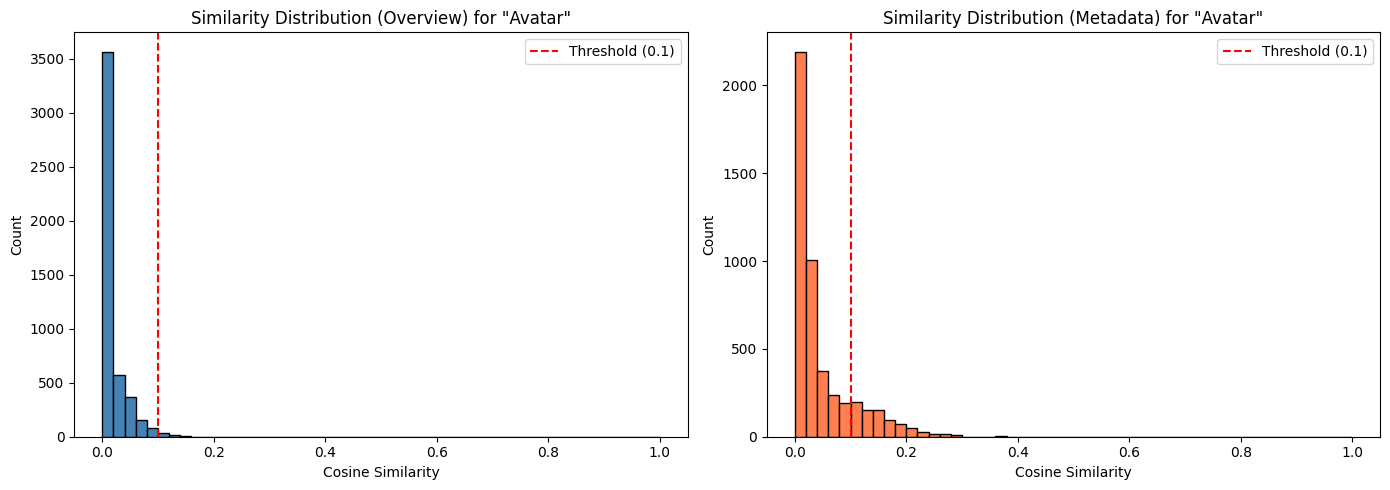

In [22]:
# Visualize similarity distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overview similarity for Avatar
avatar_sim_overview = cosine_sim_overview[avatar_idx]
axes[0].hist(avatar_sim_overview, bins=50, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Similarity Distribution (Overview) for "{df.iloc[avatar_idx]["title"]}"')
axes[0].axvline(x=0.1, color='red', linestyle='--', label='Threshold (0.1)')
axes[0].legend()

# Metadata similarity for Avatar
avatar_sim_metadata = cosine_sim_metadata[avatar_idx]
axes[1].hist(avatar_sim_metadata, bins=50, edgecolor='black', color='coral')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Similarity Distribution (Metadata) for "{df.iloc[avatar_idx]["title"]}"')
axes[1].axvline(x=0.1, color='red', linestyle='--', label='Threshold (0.1)')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 7. Building the Recommender

Now let's create functions to get movie recommendations.

In [23]:
# Create a mapping of movie titles to indices
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim_overview, top_n=10):
    """
    Get movie recommendations based on cosine similarity.

    Parameters:
        title: Movie title to get recommendations for
        cosine_sim: Similarity matrix to use
        top_n: Number of recommendations to return

    Returns:
        DataFrame with recommended movies and their similarity scores
    """
    # Handle case-insensitive matching
    title_lower = title.lower()
    matching_titles = [t for t in indices.index if t.lower() == title_lower]

    if not matching_titles:
        # Try partial matching
        matching_titles = [t for t in indices.index if title_lower in t.lower()]
        if matching_titles:
            print(f"⚠️ Exact match not found. Using: '{matching_titles[0]}'")
        else:
            print(f"❌ Movie '{title}' not found in database.")
            return pd.DataFrame()

    title = matching_titles[0]

    # Get the index of the movie
    idx = indices[title]

    # Get pairwise similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort by similarity (descending)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top N (excluding itself)
    sim_scores = sim_scores[1:top_n + 1]

    # Get movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Create results DataFrame
    results = df.iloc[movie_indices][['title', 'genres_str', 'vote_average', 'vote_count', 'director']].copy()
    results['similarity'] = [round(score[1], 4) for score in sim_scores]
    results = results.reset_index(drop=True)
    results.index = results.index + 1  # Start index from 1

    return results


print("✅ Recommendation function created!")

✅ Recommendation function created!


In [24]:
# Enhanced recommendation function with more details
def recommend_movies(title, method='overview', top_n=10, show_plot=False):
    """
    Get detailed movie recommendations.

    Parameters:
        title: Movie title
        method: 'overview' (plot-based) or 'metadata' (cast/crew/genre-based)
        top_n: Number of recommendations
        show_plot: Whether to display a similarity bar chart
    """
    # Select similarity matrix
    if method == 'metadata':
        cosine_sim = cosine_sim_metadata
        method_desc = "Metadata (Cast, Director, Genre)"
    else:
        cosine_sim = cosine_sim_overview
        method_desc = "Overview (Plot Description)"

    # Get recommendations
    results = get_recommendations(title, cosine_sim, top_n)

    if results.empty:
        return results

    # Display header
    print(f"\n{'='*60}")
    print(f"🎬 RECOMMENDATIONS FOR: '{title}'")
    print(f"📊 Method: {method_desc}")
    print(f"{'='*60}\n")

    # Show source movie info
    source_idx = indices[title] if title in indices.index else indices[[t for t in indices.index if title.lower() in t.lower()][0]]
    source_movie = df.iloc[source_idx]
    print(f"📽️ Source Movie:")
    print(f"   Title: {source_movie['title']}")
    print(f"   Genres: {source_movie['genres_str']}")
    print(f"   Director: {source_movie['director']}")
    print(f"   Rating: {source_movie['vote_average']}/10 ({source_movie['vote_count']} votes)")
    print(f"\n{'-'*60}\n")

    # Display results
    print(f"🎯 Top {len(results)} Recommendations:\n")

    for idx, row in results.iterrows():
        sim_bar = '█' * int(row['similarity'] * 20) + '░' * (20 - int(row['similarity'] * 20))
        print(f"{idx:2}. {row['title']}")
        print(f"    Similarity: [{sim_bar}] {row['similarity']:.2%}")
        print(f"    Genres: {row['genres_str']}")
        print(f"    Director: {row['director']} | Rating: {row['vote_average']}/10")
        print()

    # Optional: Show bar chart
    if show_plot:
        plt.figure(figsize=(10, 6))
        plt.barh(results['title'][::-1], results['similarity'][::-1], color='steelblue')
        plt.xlabel('Cosine Similarity')
        plt.title(f'Top {len(results)} Similar Movies to "{title}"')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

    return results

---
## 8. Testing Recommendations

Let's test our recommender with different movies!


🎬 RECOMMENDATIONS FOR: 'The Dark Knight'
📊 Method: Overview (Plot Description)

📽️ Source Movie:
   Title: The Dark Knight
   Genres: Drama Action Crime Thriller
   Director: Christopher Nolan
   Rating: 8.2/10 (12002 votes)

------------------------------------------------------------

🎯 Top 5 Recommendations:

 1. The Dark Knight Rises
    Similarity: [███████░░░░░░░░░░░░░] 39.18%
    Genres: Action Crime Drama Thriller
    Director: Christopher Nolan | Rating: 7.6/10

 2. Batman Forever
    Similarity: [██████░░░░░░░░░░░░░░] 31.07%
    Genres: Action Crime Fantasy
    Director: Joel Schumacher | Rating: 5.2/10

 3. Batman Returns
    Similarity: [█████░░░░░░░░░░░░░░░] 25.78%
    Genres: Action Fantasy
    Director: Tim Burton | Rating: 6.6/10

 4. Batman: The Dark Knight Returns, Part 2
    Similarity: [█████░░░░░░░░░░░░░░░] 25.04%
    Genres: Action Animation
    Director: Jay Oliva | Rating: 7.9/10

 5. Amidst the Devil's Wings
    Similarity: [████░░░░░░░░░░░░░░░░] 22.93%
    Ge

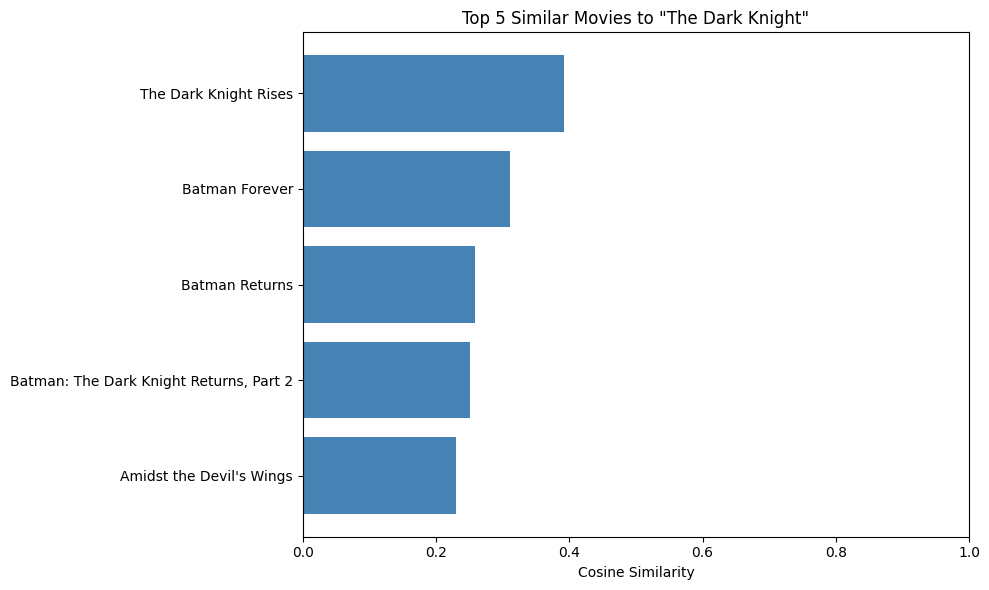

,title,genres_str,vote_average,vote_count,director,similarity
1,The Dark Knight Rises,Action Crime Drama Thriller,7.6,9106,Christopher Nolan,0.3918
2,Batman Forever,Action Crime Fantasy,5.2,1498,Joel Schumacher,0.3107
3,Batman Returns,Action Fantasy,6.6,1673,Tim Burton,0.2578
4,"Batman: The Dark Knight Returns, Part 2",Action Animation,7.9,419,Jay Oliva,0.2504
5,Amidst the Devil's Wings,Drama Action Crime,0.0,0,,0.2293


In [25]:
# Test 1: The Dark Knight (Superhero movie)
recommend_movies('The Dark Knight', method='overview', top_n=5, show_plot=True)


🎬 RECOMMENDATIONS FOR: 'The Dark Knight'
📊 Method: Metadata (Cast, Director, Genre)

📽️ Source Movie:
   Title: The Dark Knight
   Genres: Drama Action Crime Thriller
   Director: Christopher Nolan
   Rating: 8.2/10 (12002 votes)

------------------------------------------------------------

🎯 Top 5 Recommendations:

 1. The Dark Knight Rises
    Similarity: [██████████░░░░░░░░░░] 52.75%
    Genres: Action Crime Drama Thriller
    Director: Christopher Nolan | Rating: 7.6/10

 2. Batman Begins
    Similarity: [██████████░░░░░░░░░░] 50.10%
    Genres: Action Crime Drama
    Director: Christopher Nolan | Rating: 7.5/10

 3. Gangster's Paradise: Jerusalema
    Similarity: [███████░░░░░░░░░░░░░] 39.84%
    Genres: Drama Action Crime Foreign
    Director: Ralph Ziman | Rating: 6.8/10

 4. Exiled
    Similarity: [███████░░░░░░░░░░░░░] 39.44%
    Genres: Action Crime Thriller
    Director: Johnnie To | Rating: 7.0/10

 5. Amidst the Devil's Wings
    Similarity: [███████░░░░░░░░░░░░░] 39.44%

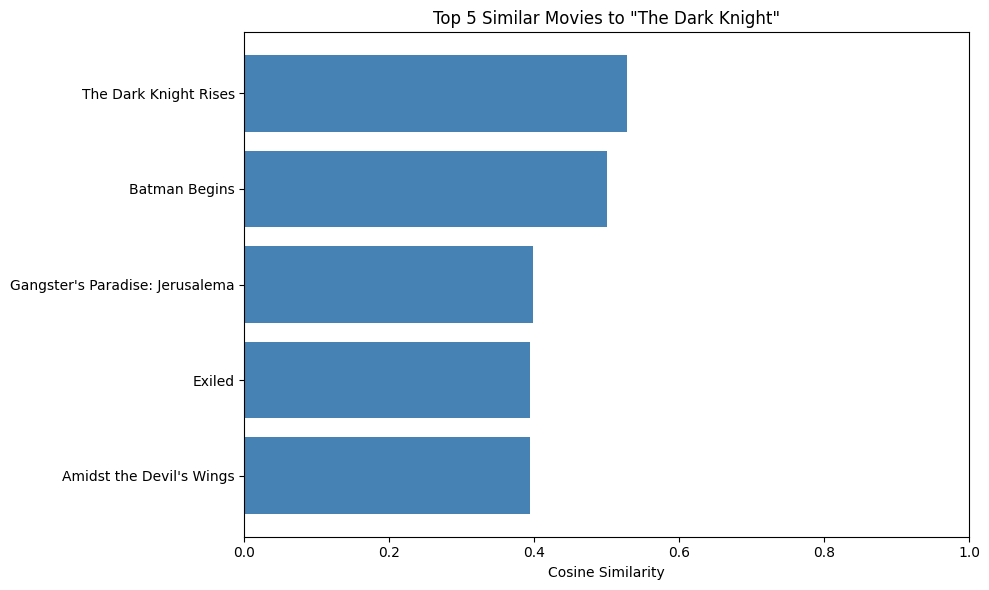

,title,genres_str,vote_average,vote_count,director,similarity
1,The Dark Knight Rises,Action Crime Drama Thriller,7.6,9106,Christopher Nolan,0.5275
2,Batman Begins,Action Crime Drama,7.5,7359,Christopher Nolan,0.5010
3,Gangster's Paradise: Jerusalema,Drama Action Crime Foreign,6.8,16,Ralph Ziman,0.3984
4,Exiled,Action Crime Thriller,7.0,46,Johnnie To,0.3944
5,Amidst the Devil's Wings,Drama Action Crime,0.0,0,,0.3944


In [26]:
# Test 2: The Dark Knight using metadata (cast, director, genres)
recommend_movies('The Dark Knight', method='metadata', top_n=5, show_plot=True)


🎬 RECOMMENDATIONS FOR: 'Avatar'
📊 Method: Overview (Plot Description)

📽️ Source Movie:
   Title: Avatar
   Genres: Action Adventure Fantasy Science Fiction
   Director: James Cameron
   Rating: 7.2/10 (11800 votes)

------------------------------------------------------------

🎯 Top 5 Recommendations:

 1. Lara Croft Tomb Raider: The Cradle of Life
    Similarity: [████░░░░░░░░░░░░░░░░] 23.34%
    Genres: Action Adventure Fantasy Thriller
    Director: Jan de Bont | Rating: 5.5/10

 2. Apollo 18
    Similarity: [████░░░░░░░░░░░░░░░░] 20.54%
    Genres: Horror Thriller Science Fiction
    Director: Gonzalo López-Gallego | Rating: 5.0/10

 3. Man of Steel
    Similarity: [███░░░░░░░░░░░░░░░░░] 16.70%
    Genres: Action Adventure Fantasy Science Fiction
    Director: Zack Snyder | Rating: 6.5/10

 4. Mad Max Beyond Thunderdome
    Similarity: [███░░░░░░░░░░░░░░░░░] 16.30%
    Genres: Action Adventure Science Fiction
    Director: George Miller | Rating: 5.9/10

 5. Dragonball Evolution


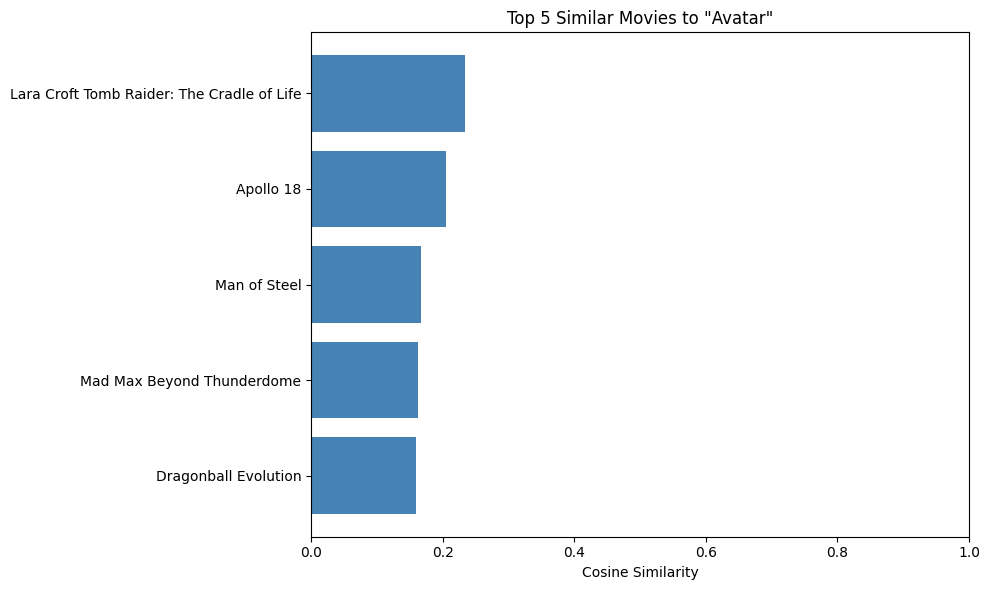

,title,genres_str,vote_average,vote_count,director,similarity
1,Lara Croft Tomb Raider: The Cradle of Life,Action Adventure Fantasy Thriller,5.5,1418,Jan de Bont,0.2334
2,Apollo 18,Horror Thriller Science Fiction,5.0,356,Gonzalo López-Gallego,0.2054
3,Man of Steel,Action Adventure Fantasy Science Fiction,6.5,6359,Zack Snyder,0.1670
4,Mad Max Beyond Thunderdome,Action Adventure Science Fiction,5.9,748,George Miller,0.1630
5,Dragonball Evolution,Action Adventure Fantasy Science Fiction Thriller,2.9,462,James Wong,0.1595


In [27]:
# Test 3: Avatar (Sci-Fi)
recommend_movies('Avatar', method='overview', top_n=5, show_plot=True)


🎬 RECOMMENDATIONS FOR: 'The Godfather'
📊 Method: Metadata (Cast, Director, Genre)

📽️ Source Movie:
   Title: The Godfather
   Genres: Drama Crime
   Director: Francis Ford Coppola
   Rating: 8.4/10 (5893 votes)

------------------------------------------------------------

🎯 Top 5 Recommendations:

 1. The Godfather: Part II
    Similarity: [███████░░░░░░░░░░░░░] 37.14%
    Genres: Drama Crime
    Director: Francis Ford Coppola | Rating: 8.3/10

 2. Mi America
    Similarity: [██████░░░░░░░░░░░░░░] 34.64%
    Genres: Drama Crime
    Director: Robert Fontaine | Rating: 0.0/10

 3. The Son of No One
    Similarity: [██████░░░░░░░░░░░░░░] 30.55%
    Genres: Drama Thriller Crime
    Director: Dito Montiel | Rating: 4.8/10

 4. Donnie Brasco
    Similarity: [█████░░░░░░░░░░░░░░░] 29.71%
    Genres: Crime Drama Thriller
    Director: Mike Newell | Rating: 7.4/10

 5. Righteous Kill
    Similarity: [█████░░░░░░░░░░░░░░░] 29.21%
    Genres: Action Crime Drama Thriller
    Director: Jon Avnet

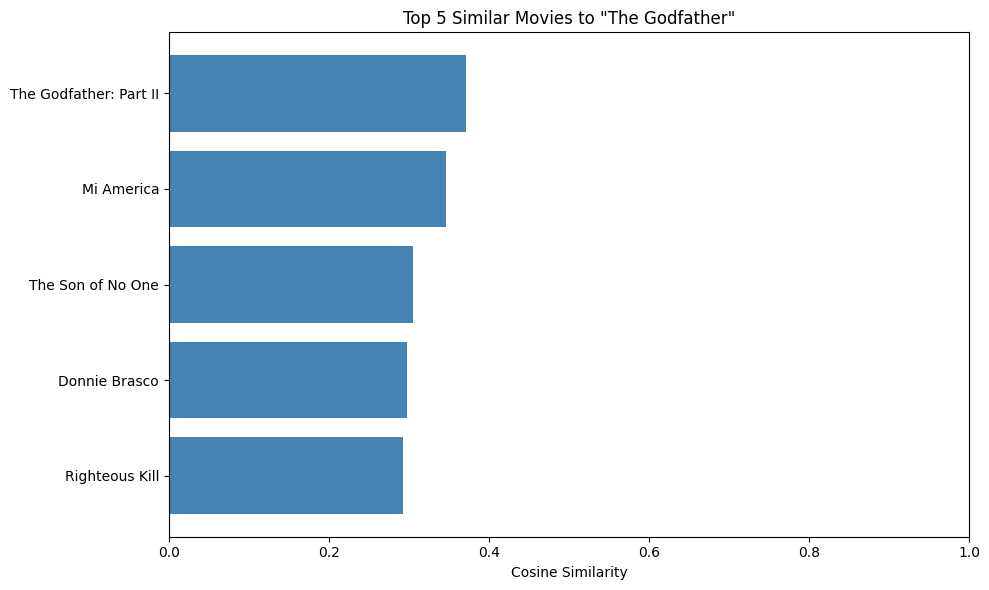

,title,genres_str,vote_average,vote_count,director,similarity
1,The Godfather: Part II,Drama Crime,8.3,3338,Francis Ford Coppola,0.3714
2,Mi America,Drama Crime,0.0,0,Robert Fontaine,0.3464
3,The Son of No One,Drama Thriller Crime,4.8,92,Dito Montiel,0.3055
4,Donnie Brasco,Crime Drama Thriller,7.4,1147,Mike Newell,0.2971
5,Righteous Kill,Action Crime Drama Thriller,5.9,375,Jon Avnet,0.2921


In [28]:
# Test 4: The Godfather (Crime Drama)
recommend_movies('The Godfather', method='metadata', top_n=5, show_plot=True)


🎬 RECOMMENDATIONS FOR: 'Toy Story'
📊 Method: Overview (Plot Description)

📽️ Source Movie:
   Title: Toy Story
   Genres: Animation Comedy Family
   Director: John Lasseter
   Rating: 7.7/10 (5269 votes)

------------------------------------------------------------

🎯 Top 5 Recommendations:

 1. Toy Story 3
    Similarity: [█████████░░░░░░░░░░░] 48.27%
    Genres: Animation Family Comedy
    Director: Lee Unkrich | Rating: 7.6/10

 2. Toy Story 2
    Similarity: [█████████░░░░░░░░░░░] 46.82%
    Genres: Animation Comedy Family
    Director: John Lasseter | Rating: 7.3/10

 3. The 40 Year Old Virgin
    Similarity: [██████░░░░░░░░░░░░░░] 31.87%
    Genres: Comedy Romance
    Director: Judd Apatow | Rating: 6.2/10

 4. Man on the Moon
    Similarity: [█████░░░░░░░░░░░░░░░] 29.85%
    Genres: Comedy Drama Romance
    Director: Miloš Forman | Rating: 6.9/10

 5. Factory Girl
    Similarity: [█████░░░░░░░░░░░░░░░] 25.44%
    Genres: Drama
    Director: George Hickenlooper | Rating: 6.2/10


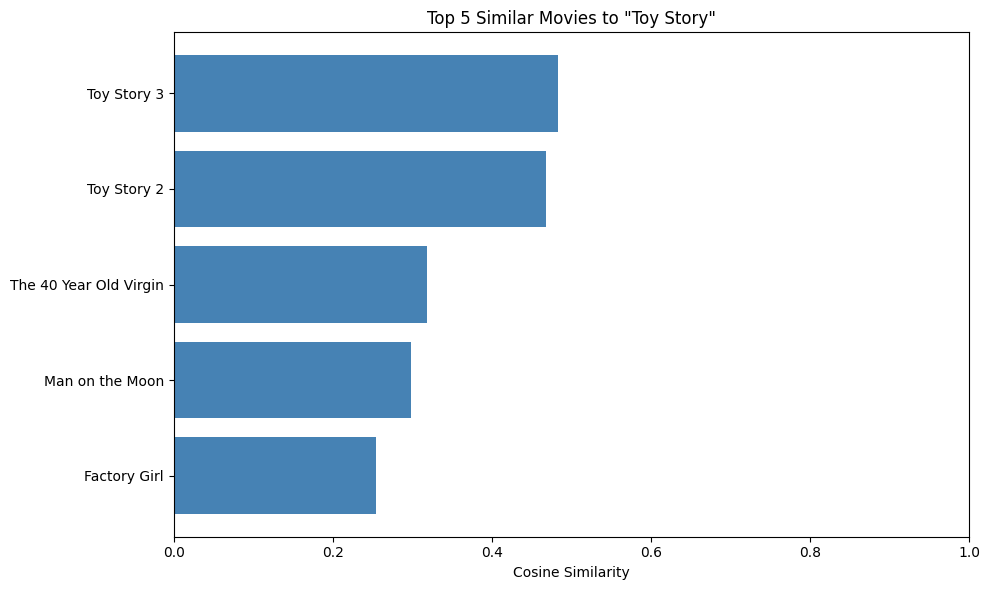

,title,genres_str,vote_average,vote_count,director,similarity
1,Toy Story 3,Animation Family Comedy,7.6,4597,Lee Unkrich,0.4827
2,Toy Story 2,Animation Comedy Family,7.3,3806,John Lasseter,0.4682
3,The 40 Year Old Virgin,Comedy Romance,6.2,1983,Judd Apatow,0.3187
4,Man on the Moon,Comedy Drama Romance,6.9,435,Miloš Forman,0.2985
5,Factory Girl,Drama,6.2,81,George Hickenlooper,0.2544


In [29]:
# Test 5: Toy Story (Animation)
recommend_movies('Toy Story', method='overview', top_n=5, show_plot=True)

In [30]:
# Compare Overview vs Metadata recommendations
print("\n" + "="*80)
print("🔍 COMPARISON: Overview vs Metadata Recommendations for 'Inception'")
print("="*80)

overview_recs = get_recommendations('Inception', cosine_sim_overview, 5)
metadata_recs = get_recommendations('Inception', cosine_sim_metadata, 5)

comparison = pd.DataFrame({
    'Rank': range(1, 6),
    'Overview-Based': overview_recs['title'].values,
    'Overview Sim': overview_recs['similarity'].values,
    'Metadata-Based': metadata_recs['title'].values,
    'Metadata Sim': metadata_recs['similarity'].values
})

print("\n")
print(comparison.to_string(index=False))

# Find overlap
overlap = set(overview_recs['title']) & set(metadata_recs['title'])
print(f"\n🔗 Movies in both lists: {overlap if overlap else 'None'}")


🔍 COMPARISON: Overview vs Metadata Recommendations for 'Inception'


 Rank                      Overview-Based  Overview Sim      Metadata-Based  Metadata Sim
    1                              Cypher        0.2592 Yesterday Was a Lie        0.3858
    2                     Minority Report        0.2492          Alien Zone        0.3722
    3               2001: A Space Odyssey        0.1969 Carousel of Revenge        0.3563
    4 Transformers: Revenge of the Fallen        0.1946              Decoys        0.3499
    5                               Signs        0.1860       Truth or Dare        0.3499

🔗 Movies in both lists: None


---
## 9. Advanced: Hybrid Recommender

Combine overview-based and metadata-based similarity for better recommendations.

In [31]:
class HybridRecommender:
    """
    A hybrid movie recommender combining multiple similarity metrics.
    """

    def __init__(self, df, cosine_sim_overview, cosine_sim_metadata):
        self.df = df
        self.cosine_sim_overview = cosine_sim_overview
        self.cosine_sim_metadata = cosine_sim_metadata
        self.indices = pd.Series(df.index, index=df['title']).drop_duplicates()

    def _find_movie(self, title):
        """Find movie by title with fuzzy matching."""
        title_lower = title.lower()

        # Exact match
        matches = [t for t in self.indices.index if t.lower() == title_lower]
        if matches:
            return matches[0]

        # Partial match
        matches = [t for t in self.indices.index if title_lower in t.lower()]
        if matches:
            return matches[0]

        return None

    def recommend(self, title, top_n=10, overview_weight=0.5,
                  min_votes=50, min_rating=0):
        """
        Get hybrid recommendations.

        Parameters:
            title: Movie title
            top_n: Number of recommendations
            overview_weight: Weight for overview similarity (0-1)
            min_votes: Minimum vote count filter
            min_rating: Minimum rating filter
        """
        # Find movie
        matched_title = self._find_movie(title)
        if not matched_title:
            print(f"❌ Movie '{title}' not found!")
            return pd.DataFrame()

        idx = self.indices[matched_title]
        metadata_weight = 1 - overview_weight

        # Combine similarities
        combined_sim = (overview_weight * self.cosine_sim_overview[idx] +
                       metadata_weight * self.cosine_sim_metadata[idx])

        # Get scores with indices
        sim_scores = list(enumerate(combined_sim))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Filter and collect results
        results = []
        for i, score in sim_scores:
            if i == idx:  # Skip self
                continue

            movie = self.df.iloc[i]

            # Apply filters
            if movie['vote_count'] < min_votes:
                continue
            if movie['vote_average'] < min_rating:
                continue

            results.append({
                'title': movie['title'],
                'genres': movie['genres_str'],
                'director': movie['director'],
                'rating': movie['vote_average'],
                'votes': movie['vote_count'],
                'combined_sim': round(score, 4),
                'overview_sim': round(self.cosine_sim_overview[idx][i], 4),
                'metadata_sim': round(self.cosine_sim_metadata[idx][i], 4)
            })

            if len(results) >= top_n:
                break

        return pd.DataFrame(results)

    def recommend_for_user(self, liked_movies, top_n=10, min_votes=50):
        """
        Recommend movies based on multiple liked movies.
        """
        if not liked_movies:
            return pd.DataFrame()

        # Aggregate similarities
        combined_sim = np.zeros(len(self.df))
        valid_count = 0

        liked_indices = set()

        for title in liked_movies:
            matched = self._find_movie(title)
            if matched:
                idx = self.indices[matched]
                liked_indices.add(idx)
                combined_sim += (0.5 * self.cosine_sim_overview[idx] +
                                0.5 * self.cosine_sim_metadata[idx])
                valid_count += 1

        if valid_count == 0:
            return pd.DataFrame()

        # Average the similarities
        combined_sim /= valid_count

        # Get top recommendations
        sim_scores = list(enumerate(combined_sim))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        results = []
        for i, score in sim_scores:
            if i in liked_indices:  # Skip liked movies
                continue

            movie = self.df.iloc[i]
            if movie['vote_count'] < min_votes:
                continue

            results.append({
                'title': movie['title'],
                'genres': movie['genres_str'],
                'director': movie['director'],
                'rating': movie['vote_average'],
                'similarity': round(score, 4)
            })

            if len(results) >= top_n:
                break

        return pd.DataFrame(results)


# Initialize hybrid recommender
hybrid = HybridRecommender(df, cosine_sim_overview, cosine_sim_metadata)
print("✅ Hybrid Recommender initialized!")

✅ Hybrid Recommender initialized!


In [32]:
# Test hybrid recommender
print("\n" + "="*70)
print("🎬 HYBRID RECOMMENDATIONS FOR 'Interstellar'")
print("   (50% Overview + 50% Metadata, min 100 votes)")
print("="*70 + "\n")

hybrid_recs = hybrid.recommend(
    'Interstellar',
    top_n=10,
    overview_weight=0.5,
    min_votes=100
)

print(hybrid_recs.to_string(index=False))


🎬 HYBRID RECOMMENDATIONS FOR 'Interstellar'
   (50% Overview + 50% Metadata, min 100 votes)

                       title                                  genres              director  rating  votes  combined_sim  overview_sim  metadata_sim
              Silent Running         Adventure Drama Science Fiction      Douglas Trumbull     6.3    177        0.2567        0.1431        0.3703
                     Solaris Drama Science Fiction Adventure Mystery      Andrei Tarkovsky     7.7    357        0.2061        0.1592        0.2530
            Midnight Special         Adventure Drama Science Fiction          Jeff Nichols     6.2    694        0.1952        0.1728        0.2177
                 The Martian         Drama Adventure Science Fiction          Ridley Scott     7.6   7268        0.1890        0.0716        0.3064
                     Contact           Drama Science Fiction Mystery       Robert Zemeckis     7.2   1308        0.1853        0.1584        0.2121
        The Astron

In [33]:
# Test user-based recommendations
print("\n" + "="*70)
print("👤 USER-BASED RECOMMENDATIONS")
print("   Liked Movies: Inception, The Matrix, Interstellar")
print("="*70 + "\n")

user_recs = hybrid.recommend_for_user(
    ['Inception', 'The Matrix', 'Interstellar'],
    top_n=10,
    min_votes=100
)

print(user_recs.to_string(index=False))


👤 USER-BASED RECOMMENDATIONS
   Liked Movies: Inception, The Matrix, Interstellar

                 title                                                  genres         director  rating  similarity
   The Matrix Reloaded               Adventure Action Thriller Science Fiction  Lilly Wachowski     6.7      0.2183
The Matrix Revolutions               Adventure Action Thriller Science Fiction  Lilly Wachowski     6.4      0.2033
 2001: A Space Odyssey                       Science Fiction Mystery Adventure  Stanley Kubrick     7.9      0.1488
               Solaris                 Drama Science Fiction Adventure Mystery Andrei Tarkovsky     7.7      0.1471
               Gattaca                Thriller Science Fiction Mystery Romance    Andrew Niccol     7.5      0.1440
       Minority Report                 Action Thriller Science Fiction Mystery Steven Spielberg     7.1      0.1425
            Red Planet                         Thriller Action Science Fiction   Antony Hoffman     5.4 

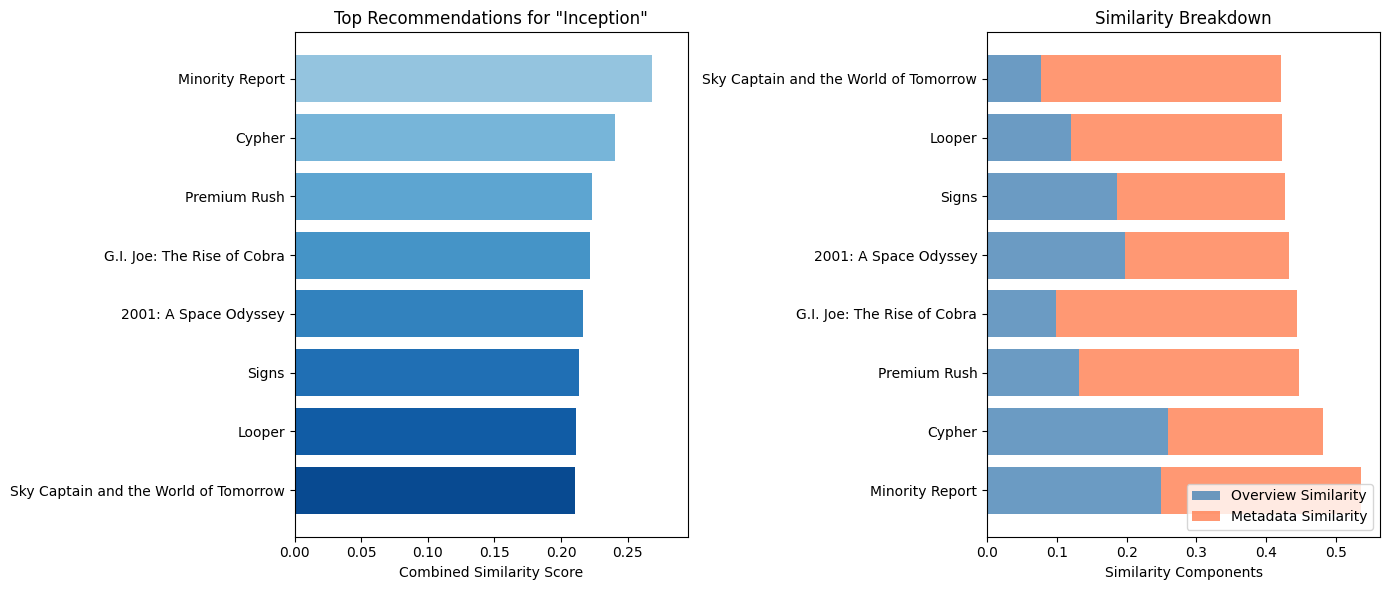

In [34]:
# Visualize hybrid recommendations
def visualize_recommendations(title, recs_df):
    """Create a visualization of recommendations."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Bar chart of similarity scores
    ax1 = axes[0]
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(recs_df)))
    ax1.barh(recs_df['title'][::-1], recs_df['combined_sim'][::-1], color=colors[::-1])
    ax1.set_xlabel('Combined Similarity Score')
    ax1.set_title(f'Top Recommendations for "{title}"')
    ax1.set_xlim(0, max(recs_df['combined_sim']) * 1.1)

    # Stacked bar chart showing component similarities
    ax2 = axes[1]
    y_pos = np.arange(len(recs_df))

    ax2.barh(y_pos, recs_df['overview_sim'], label='Overview Similarity', color='steelblue', alpha=0.8)
    ax2.barh(y_pos, recs_df['metadata_sim'], left=recs_df['overview_sim'],
             label='Metadata Similarity', color='coral', alpha=0.8)

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(recs_df['title'])
    ax2.set_xlabel('Similarity Components')
    ax2.set_title('Similarity Breakdown')
    ax2.legend(loc='lower right')

    plt.tight_layout()
    plt.show()


# Visualize recommendations for Inception
inception_recs = hybrid.recommend('Inception', top_n=8, min_votes=100)
visualize_recommendations('Inception', inception_recs)

---
## 10. Interactive Demo

Create an interactive widget for exploring recommendations.

In [35]:
# Function for easy movie search
def search_movies(query, top_n=10):
    """Search for movies by title."""
    query_lower = query.lower()
    matches = df[df['title'].str.lower().str.contains(query_lower, na=False)]

    if matches.empty:
        print(f"❌ No movies found matching '{query}'")
        return pd.DataFrame()

    results = matches[['title', 'genres_str', 'vote_average', 'vote_count', 'release_date']].head(top_n)
    results = results.rename(columns={
        'genres_str': 'genres',
        'vote_average': 'rating',
        'vote_count': 'votes',
        'release_date': 'year'
    })

    return results.reset_index(drop=True)


# Test search
print("🔍 Search: 'star'")
print(search_movies('star', 10).to_string(index=False))

🔍 Search: 'star'
                                       title                                    genres  rating  votes       year
                     Star Trek Into Darkness          Action Adventure Science Fiction     7.4   4418 2013-05-05
                            Star Trek Beyond          Action Adventure Science Fiction     6.6   2568 2016-07-07
                                   Star Trek          Science Fiction Action Adventure     7.4   4518 2009-05-06
Star Wars: Episode III - Revenge of the Sith          Science Fiction Adventure Action     7.1   4116 2005-05-17
Star Wars: Episode II - Attack of the Clones          Adventure Action Science Fiction     6.4   3992 2002-05-15
   Star Wars: Episode I - The Phantom Menace          Adventure Action Science Fiction     6.3   4432 1999-05-19
                           Starship Troopers Adventure Action Thriller Science Fiction     6.7   1560 1997-11-06
                     Star Trek: Insurrection Science Fiction Action Adventure T

In [36]:
# Interactive recommendation function
def interactive_recommend(movie_title, method='hybrid', top_n=10,
                          overview_weight=0.5, min_votes=50, min_rating=0):
    """
    Interactive movie recommendation with formatted output.

    Parameters:
        movie_title: Title of the movie
        method: 'overview', 'metadata', or 'hybrid'
        top_n: Number of recommendations
        overview_weight: Weight for overview (only for hybrid)
        min_votes: Minimum vote count
        min_rating: Minimum rating
    """
    print("\n" + "🎬" * 30)
    print(f"\n   MOVIE RECOMMENDATION SYSTEM")
    print(f"\n" + "🎬" * 30)

    if method == 'hybrid':
        recs = hybrid.recommend(movie_title, top_n, overview_weight, min_votes, min_rating)
        method_desc = f"Hybrid ({overview_weight:.0%} Overview + {1-overview_weight:.0%} Metadata)"
    elif method == 'metadata':
        recs = get_recommendations(movie_title, cosine_sim_metadata, top_n)
        method_desc = "Metadata (Cast, Director, Genres)"
    else:
        recs = get_recommendations(movie_title, cosine_sim_overview, top_n)
        method_desc = "Overview (Plot Description)"

    if recs.empty:
        return

    # Display info
    print(f"\n📽️ Input Movie: {movie_title}")
    print(f"📊 Method: {method_desc}")
    print(f"🎯 Filters: min_votes={min_votes}, min_rating={min_rating}")
    print(f"\n" + "-" * 60)
    print(f"\n🎯 TOP {len(recs)} RECOMMENDATIONS:\n")

    for i, row in recs.iterrows():
        if method == 'hybrid':
            sim = row['combined_sim']
            title = row['title']
            genres = row['genres']
            rating = row['rating']
        else:
            sim = row['similarity']
            title = row['title']
            genres = row['genres_str']
            rating = row['vote_average']

        sim_bar = '█' * int(sim * 20) + '░' * (20 - int(sim * 20))

        rank = i if method == 'hybrid' else i
        print(f"  {rank:2}. {title}")
        print(f"      Match: [{sim_bar}] {sim:.1%}")
        print(f"      Genre: {genres}")
        print(f"      Rating: {'⭐' * int(rating/2)} {rating}/10")
        print()

    return recs

In [37]:
# Demo: Different recommendations
interactive_recommend('The Avengers', method='hybrid', top_n=5, min_votes=100)


🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬

   MOVIE RECOMMENDATION SYSTEM

🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬🎬

📽️ Input Movie: The Avengers
📊 Method: Hybrid (50% Overview + 50% Metadata)
🎯 Filters: min_votes=100, min_rating=0

------------------------------------------------------------

🎯 TOP 5 RECOMMENDATIONS:

   0. Avengers: Age of Ultron
      Match: [██████████░░░░░░░░░░] 51.1%
      Genre: Action Adventure Science Fiction
      Rating: ⭐⭐⭐ 7.3/10

   1. Captain America: Civil War
      Match: [██████░░░░░░░░░░░░░░] 30.3%
      Genre: Adventure Action Science Fiction
      Rating: ⭐⭐⭐ 7.1/10

   2. Captain America: The Winter Soldier
      Match: [█████░░░░░░░░░░░░░░░] 28.1%
      Genre: Action Adventure Science Fiction
      Rating: ⭐⭐⭐ 7.6/10

   3. Ant-Man
      Match: [█████░░░░░░░░░░░░░░░] 27.7%
      Genre: Science Fiction Action Adventure
      Rating: ⭐⭐⭐ 7.0/10

   4. Iron Man 2
      Match: [█████░░░░░░░░░░░░░░░] 25.2%
      Genre: Adventure Action Science Fiction
      Rating: ⭐⭐⭐ 6

,title,genres,director,rating,votes,combined_sim,overview_sim,metadata_sim
0,Avengers: Age of Ultron,Action Adventure Science Fiction,Joss Whedon,7.3,6767,0.5107,0.1906,0.8309
1,Captain America: Civil War,Adventure Action Science Fiction,Anthony Russo,7.1,7241,0.3035,0.0616,0.5455
2,Captain America: The Winter Soldier,Action Adventure Science Fiction,Anthony Russo,7.6,5764,0.2807,0.1096,0.4518
3,Ant-Man,Science Fiction Action Adventure,Peyton Reed,7.0,5880,0.2766,0.1330,0.4202
4,Iron Man 2,Adventure Action Science Fiction,Jon Favreau,6.6,6849,0.2518,0.0511,0.4526


In [38]:
# Try with different movies
test_movies = ['Titanic', 'The Matrix', 'Frozen', 'The Godfather', 'Finding Nemo']

for movie in test_movies:
    print("\n" + "="*70)
    print(f"Recommendations for '{movie}':")
    print("="*70)

    recs = hybrid.recommend(movie, top_n=3, min_votes=50)
    if not recs.empty:
        for _, row in recs.iterrows():
            print(f"  → {row['title']} ({row['genres']}) - {row['combined_sim']:.1%} match")


Recommendations for 'Titanic':
  → The Switch (Comedy Romance Drama) - 15.9% match
  → Angel Eyes (Drama Romance Thriller) - 15.8% match
  → The Time Traveler's Wife (Drama Romance Fantasy) - 15.2% match

Recommendations for 'The Matrix':
  → The Matrix Reloaded (Adventure Action Thriller Science Fiction) - 42.7% match
  → The Matrix Revolutions (Adventure Action Thriller Science Fiction) - 35.2% match
  → Red Planet (Thriller Action Science Fiction) - 23.0% match

Recommendations for 'Frozen':
  → Spirit: Stallion of the Cimarron (Western Animation Adventure Comedy Family) - 34.3% match
  → Penguins of Madagascar (Family Animation Adventure Comedy) - 27.1% match
  → The Land Before Time (Animation Adventure Family) - 26.2% match

Recommendations for 'The Godfather':
  → The Godfather: Part II (Drama Crime) - 39.5% match
  → The Godfather: Part III (Crime Drama Thriller) - 22.3% match
  → Easy Money (Drama Thriller Crime) - 18.9% match

Recommendations for 'Finding Nemo':
  → Mr. Bean

In [39]:
# Create interactive widget (works in Colab)
try:
    from ipywidgets import interact, widgets

    # Get list of popular movies for dropdown
    popular_movies = df.nlargest(100, 'popularity')['title'].tolist()

    @interact(
        movie=widgets.Combobox(options=popular_movies, value='Avatar', description='Movie:'),
        method=widgets.Dropdown(options=['hybrid', 'overview', 'metadata'], value='hybrid'),
        top_n=widgets.IntSlider(min=3, max=15, value=5, description='Results:'),
        overview_weight=widgets.FloatSlider(min=0, max=1, value=0.5, step=0.1, description='Plot Weight:'),
        min_votes=widgets.IntSlider(min=0, max=500, value=50, step=25, description='Min Votes:')
    )
    def widget_recommend(movie, method, top_n, overview_weight, min_votes):
        interactive_recommend(movie, method, top_n, overview_weight, min_votes)

except ImportError:
    print("ℹ️ Interactive widgets not available. Use interactive_recommend() function directly.")
    print("\nExample:")
    print("  interactive_recommend('Avatar', method='hybrid', top_n=5)")

interactive(children=(Combobox(value='Avatar', description='Movie:', options=('Minions', 'Interstellar', 'Dead…

---
## 📊 Summary

### What We Built:

1. **Data Pipeline**: Downloaded and processed TMDB 5000 movie dataset
2. **Feature Engineering**: Extracted genres, keywords, cast, and director
3. **Text Representation**: Used TF-IDF and Count Vectorization
4. **Similarity Calculation**: Computed cosine similarity matrices
5. **Recommender Systems**:
   - Overview-based (plot similarity)
   - Metadata-based (cast, director, genre similarity)
   - Hybrid (combination of both)
   - User-profile based (multiple liked movies)

### Key Concepts:

| Technique | Purpose |
|-----------|--------|
| TF-IDF | Convert text to weighted numerical vectors |
| Count Vectorizer | Simple word frequency vectors |
| Cosine Similarity | Measure similarity between vectors |
| Hybrid Approach | Combine multiple similarity metrics |

### Next Steps:

- Add collaborative filtering (user ratings)
- Implement matrix factorization (SVD)
- Deploy as a REST API using FastAPI
- Add neural network embeddings (word2vec, BERT)

In [40]:
# Save the model for later use
import pickle

# Create a dictionary with all necessary objects
model_data = {
    'df': df[['id', 'title', 'genres_str', 'vote_average', 'vote_count', 'director', 'overview']],
    'cosine_sim_overview': cosine_sim_overview,
    'cosine_sim_metadata': cosine_sim_metadata,
    'indices': indices
}

# Save to file
with open('movie_recommender_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✅ Model saved to 'movie_recommender_model.pkl'")
print(f"   File size: {os.path.getsize('movie_recommender_model.pkl') / 1e6:.2f} MB")

✅ Model saved to 'movie_recommender_model.pkl'
   File size: 371.06 MB


In [41]:
# Download the model file (Colab only)
try:
    from google.colab import files
    files.download('movie_recommender_model.pkl')
    print("📥 Download started!")
except:
    print("ℹ️ Not in Colab. Model saved locally.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Download started!


---
## 🎉 Congratulations!

You've built a complete movie recommendation system using:
- **TF-IDF Vectorization** for text representation
- **Cosine Similarity** for finding similar movies
- **Hybrid Approach** combining plot and metadata features

Feel free to experiment with different movies and parameters!

---
*Created for NLP Text Representation Tutorial*